# Feature Engineering - Mengajari Mesin "Melihat" Molekul

bayangin gini: kita pengen mesin ngerti molekul, tapi mesin nggak bisa liat gambar atau diagram kimia kayak kita. Mesin cuma ngerti angka. Jadi kita harus ubah molekul itu jadi bahasa angka, alias vektor numerik. Nah, proses ngeubah molekul jadi angka ini yang namanya feature engineering.

## Merepresentasikan Molekul (Ligan)

Ada dua cara utama yang akan kita gunakan untuk merepresentasikan ligan.

### Morgan Fingerprints (untuk Model Baseline)

Salah satu cara paling simpel tapi powerful buat ligan (molekul kecil yang bisa nempel ke protein target) itu pake Morgan Fingerprints. Bayangin vektornya kayak rangkaian kotak kecil, masing-masing kotak bisa 0 atau 1. Setiap kotak itu bilang “ada nggak sih potongan kimia tertentu di molekul ini?” Jadi mesin nggak perlu liat gambarnya, dia cuma liat pola 0 dan 1 yang nunjukin struktur kimianya.

Morgan Fingerprints ini agak spesial karena dia nggak cuma liat atom satu per satu, tapi liat lingkungan sekeliling tiap atom sampai radius tertentu—kayak “gimana tetangga-tetangga atom ini”. Dengan cara ini, mesin bisa nangkep fitur lokal penting yang biasanya menentukan apakah molekul itu aktif atau nggak terhadap target biologis. Konsepnya mirip sama ECFP (Extended-Connectivity Fingerprints), yang udah terbukti jitu buat prediksi aktivitas obat.

Dengan representasi ini, kita udah ngajarin mesin “melihat” molekul tanpa harus paham kimia tingkat tinggi. Mesin bisa belajar dari pola-pola biner itu untuk nebak molekul mana yang mungkin bereaksi dengan protein target, yang artinya kita bisa mempercepat proses nemuin calon obat potensial. Tanpa ini, AI cuma bengong, nggak ngerti struktur molekul sama sekali.

In [2]:
!pip3.11 install -q numpy==1.26.4 pandas scipy --upgrade --no-cache-dir

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from rdkit.Chem import rdFingerprintGenerator

final_df = pd.read_csv('../data/EGFR_bioactivity_cleaned.csv')

def generate_morgan_fingerprints(smiles_list, radius=2, n_bits=2048):
    """
    Menghasilkan Morgan fingerprints dari daftar SMILES pakai API baru RDKit.
    """
    gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)

    fingerprints = []
    failed_count = 0
    
    for smiles in tqdm(smiles_list, desc="Generating Fingerprints"):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                fp = gen.GetFingerprint(mol)          # hasil langsung fingerprint generator
                arr = np.zeros((1,), dtype=int)
                Chem.DataStructs.ConvertToNumpyArray(fp, arr)
                fingerprints.append(arr)
            else:
                fingerprints.append(np.zeros(n_bits, dtype=int))
                failed_count += 1
        except Exception:
            fingerprints.append(np.zeros(n_bits, dtype=int))
            failed_count += 1
    
    print(f"SMILES gagal parse: {failed_count}")
    return np.array(fingerprints)

### Representasi Graf (untuk GNN)

sekarang kita masuk ke level berikutnya, yang lebih canggih dari Morgan Fingerprints. Jadi bayangin molekul nggak cuma sebagai gambar 2D atau rangkaian 0-1, tapi sebagai graf. Graf itu konsep matematika, dimana atom-atom jadi node (simpul) dan ikatan kimia jadi edge (sisi) yang nyambungin node-node itu.

Dengan cara ini, kita nggak kehilangan info penting tentang topologi molekul—misal, atom mana yang nyambung ke siapa, atau ada cincin aromatik nggak. Ini penting banget, soalnya kadang urutan dan koneksi antar atom menentukan aktivitas molekul lebih dari sekadar substruktur lokal yang ditangkap fingerprint.

Nah, biar mesin bisa ngerti graf ini, kita ubah molekul RDKit jadi objek Data dari PyTorch Geometric, yang memang standar buat Graph Neural Network (GNN). Dalam objek ini ada beberapa bagian:
- x: ini matriks fitur untuk tiap node/atom. Setiap baris nyimpen info atom itu—nomor atom, muatan, jumlah hidrogen, aromatik atau nggak, dan fitur lain. Jadi tiap atom punya “identitasnya” dalam angka.
- edge_index: ini nyimpen koneksi antar atom. Bayangin daftar pasangan indeks atom yang nyambung, jadi mesin ngerti siapa nyambung sama siapa.
- edge_attr: ini fitur untuk tiap edge/ikatan. Misal ikatannya tunggal, ganda, rangkap tiga, atau aromatik. Jadi mesin bisa ngerti “jenis koneksi” antar atom.

In [5]:
!pip install -q torch==2.8.0
!pip install -q torch_geometric


In [2]:
# RDKit & PyTorch
from rdkit import Chem
import torch

# PyTorch Geometric
from torch_geometric.data import Data

# Fungsi membuat fitur atom dan ikatan
def atom_features(atom):
    """
    Membuat fitur atom berbasis properti dasar.
    """
    return [
        atom.GetAtomicNum(),               # Nomor atom
        atom.GetTotalDegree(),             # Derajat (jumlah ikatan)
        atom.GetFormalCharge(),            # Muatan formal
        atom.GetTotalNumHs(),              # Jumlah H terikat
        atom.GetTotalValence(),         # Valensi implisit
        int(atom.GetIsAromatic()),         # Aromatik atau tidak (0/1)
    ]

def bond_features(bond):
    """
    Membuat fitur ikatan berbasis tipe ikatan.
    """
    return [
        bond.GetBondTypeAsDouble(),        # Tipe ikatan (1.0, 2.0, 3.0)
        int(bond.GetIsConjugated()),       # Apakah ikatan terkonjugasi
        int(bond.IsInRing()),              # Apakah ikatan dalam ring
    ]

def smiles_to_pyg_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)

    # Node features
    atom_features_list = [atom_features(atom) for atom in mol.GetAtoms()]
    x = torch.tensor(atom_features_list, dtype=torch.float)

    # Edge index & edge features
    edge_indices = []
    edge_attrs = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        bf = bond_features(bond)

        # dua arah
        edge_indices.append((i, j))
        edge_indices.append((j, i))
        edge_attrs.append(bf)
        edge_attrs.append(bf)

    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attrs, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Contoh
contoh_graf = smiles_to_pyg_graph("CCO")  # Etanol
print(contoh_graf)

Data(x=[3, 6], edge_index=[2, 4], edge_attr=[4, 3])


Hasil akhirnya bakal kayak gini: Data(x=[3,6], edge_index=[2,4], edge_attr=[4,3]). Artinya mesin punya semua info atom dan ikatan dalam format yang siap dipelajari GNN.

Dengan representasi graf, mesin bisa “ngeliat” molekul hampir kayak cara manusia kimia liatnya—dia bisa nangkep pola konektivitas, cincin aromatik, dan fitur topologi yang penting buat aktivitas biologis. Ini bikin prediksi AI lebih akurat dibanding cuma pakai fingerprint, karena GNN bisa belajar interaksi kompleks antar atom, bukan cuma “ada potongan A, ada potongan B”. Dengan ini, peluang nemuin calon obat potensial meningkat karena model bener-bener ngerti struktur molekul, bukan cuma polanya di atas kertas.

## Memahami Bahasa Protein (Target)

sekarang kita ngobrolin sisi protein, alias target obatnya. Sama kayak ligan, mesin nggak ngerti sekuens protein mentah kayak kita baca huruf. Jadi kita harus ubah protein jadi bahasa yang bisa dimengerti mesin—angka juga.

### Protein Language Models (PLMs) & ESM-2
 
Bayangin sekuens asam amino protein itu kayak kalimat panjang. Tiap asam amino itu “kata”-nya. Nah, Protein Language Models (PLMs) kayak ESM-2 itu dilatih mirip kayak model bahasa manusia—tapi ini dilatih di jutaan kalimat protein dari database besar kayak UniProt. Dari pelatihan itu, model belajar “tata bahasa biologi”: pola-pola yang bikin sekuens bisa melipat ke struktur 3D, nyusun situs aktif, dan menentukan fungsi biologisnya.

Hasilnya disebut embedding, yaitu vektor numerik berdimensi tinggi yang merangkum semua info penting protein—kayak resume lengkap protein itu dalam angka. Kerennya, kita nggak perlu struktur 3D eksperimental, yang sering susah atau nggak ada. Cukup sekuens 1D aja, mesin udah bisa ngerti banyak hal tentang protein.

Praktisnya, kita pakai library transformers dari Hugging Face, load model ESM-2 (esm2_t33_650M_UR50D), terus extract embedding protein target kita, misal EGFR. Embedding ini nanti bisa digabung sama fitur ligan (Morgan Fingerprints atau graf) biar model bisa prediksi interaksi ligan-protein.

In [7]:
!pip3.11 install -q biopython transformers

In [3]:
# Bioinformatics
from Bio.PDB import PDBParser
from Bio.Data import IUPACData

# Transformers (ESM-2)
from transformers import AutoTokenizer, EsmModel

# Fungsi mapping 3-letter ke 1-letter amino acid
three_to_one = {k.upper(): v for k, v in IUPACData.protein_letters_3to1.items()}

def get_protein_sequence_from_pdb(pdb_file):
    """
    Mengekstrak sekuens asam amino dari file PDB.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('protein', pdb_file)
    sequences = []

    for chain in structure.get_chains():
        seq = ""
        for residue in chain:
            resname = residue.get_resname().upper()
            if resname in three_to_one:
                seq += three_to_one[resname]
        if seq:
            sequences.append(seq)

    # Gunakan sekuens terpanjang sebagai representasi
    return max(sequences, key=len) if sequences else None

def get_protein_embedding(sequence, model_name="facebook/esm2_t33_650M_UR50D"):
    """
    Menghasilkan embedding untuk sekuens protein menggunakan model ESM-2.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = EsmModel.from_pretrained(model_name)

    inputs = tokenizer(sequence, return_tensors="pt", add_special_tokens=True)

    with torch.no_grad():
        outputs = model(**inputs)

    # Gunakan embedding dari token CLS (posisi 0)
    embedding = outputs.last_hidden_state[:, 0, :].squeeze()
    return embedding

# Contoh penggunaan
pdb_file = "../data/pdb/pdb2gs2.ent"  # path ke file PDB
protein_sequence = get_protein_sequence_from_pdb(pdb_file)

if protein_sequence:
    print(f"Sekuens Protein (100 pertama):\n{protein_sequence[:100]}...")
    protein_embedding = get_protein_embedding(protein_sequence)
    print(f"\nBentuk Protein Embedding: {protein_embedding.shape}")
else:
    print("Gagal mengekstrak sekuens protein.")

Sekuens Protein (100 pertama):
GEAPNQALLRILKETEFKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKEATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLITQLMPFGCL...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Bentuk Protein Embedding: torch.Size([1280])


Dengan cara ini, kita bisa kasih mesin “mata” buat protein meskipun nggak punya struktur lengkapnya. Mesin bisa belajar pola interaksi protein-ligan lebih akurat, memperbesar peluang nemuin calon obat yang bener-bener efektif.

## Kesimpulan ligan-protein.

Bayangin ligan itu kayak kunci dan protein target itu gembok. Kunci punya bentuk dan fitur kimia spesifik, gembok punya bentuk, mekanisme, dan pola tersembunyi yang bikin kunci bisa masuk atau nggak. Kalau kita cuma liat kunci aja (ligan) atau cuma liat gembok aja (protein), mesin cuma bisa nebak setengah-setengah. Tapi kalau kita gabungin kedua info ini, mesin bisa belajar apa bagian kunci yang cocok sama bagian gembok.

Secara teknis, kita ambil representasi graf ligan yang udah di-agregasi—ini kayak nyimpulin semua fitur atom dan ikatan penting jadi satu vektor. Terus kita gabungin dengan embedding protein dari ESM-2—vektor berdimensi tinggi yang nunjukin pola evolusi, struktur, dan fungsi protein. Gabungan ini jadi input multi-modal ke GNN kita.

Dengan cara ini, GNN nggak cuma liat fitur kimia atau bentuk ligan secara terpisah, tapi bener-bener belajar interaksi antara molekul dan target. Jadi prediksi IC50 atau aktivitas biologis yang dihasilkan lebih akurat, lebih general, dan jauh lebih kuat dibanding pendekatan lama kayak QSAR tradisional yang cuma fokus ligan, atau docking statis yang cuma liat struktur satu waktu.

Ini inti kenapa pendekatan modern bisa ngebantu drug discovery lebih cepat dan efektif. Mesin belajar pola kompleks yang susah ditangkap manusia, bisa nyaring molekul potensial lebih cepat, dan ngasih insight buat calon obat yang mungkin efektif sebelum diuji di laboratorium. Jadi kita nggak lagi asal nebak—AI sekarang bisa “ngeliat kunci dan gembok” sekaligus, dan itu game-changer banget buat nemuin obat baru.

---

# MODEL

sekarang kita udah masuk ke bagian yang paling seru: bikin mesinnya beneran belajar alias pemodelan AI. Jadi anggep semua proses sebelumnya itu kayak kita lagi nyiapin bahan—bersihin, ngecek kualitas, sampai bener-bener siap diolah. Nah di sini kita mulai masakannya: bikin model prediksi yang bisa nebak seberapa aktif molekul baru.

Pertama, kita biasanya mulai dari model baseline dulu. Ini ibaratnya kayak benchmark atau titik awal. Model baseline nggak harus yang paling canggih, tapi cukup kuat buat kasih kita gambaran performa minimal. Dari situ baru kita coba model yang lebih advance kayak Graph Neural Network (GNN). Kenapa GNN? Karena molekul kan sebenernya bentuknya grafik: atom-atom itu node, ikatan-ikatannya edge. Jadi GNN bisa langsung belajar dari bentuk aslinya, bukan cuma angka-angka ringkasan kayak deskriptor biasa.

## SPLITTING

Tapi sebelum masuk ke training, ada satu hal yang super penting: cara bagi data. Jangan dianggap remeh, bro. Kalo salah, hasilnya bisa ngibulin kita sendiri.

Masalah paling umum adalah kalo kita pake random split. Jadi bayangin kita punya satu seri molekul mirip-mirip—bedanya cuma tambahin satu gugus metil, ganti posisi halogen, gitu-gitu doang. Nah kalo dibagi random, kemungkinan besar versi mirip-mirip ini bakal nyebar ke train, valid, sama test. Hasilnya? Model keliatan jago banget di test set. Padahal aslinya dia cuma “ngafalin” keluarga molekul yang sama. Bukan jago generalisasi, tapi lebih kayak bocoran soal ujian.

Makanya, buat bikin simulasi dunia nyata, kita pake yang namanya scaffold splitting. Di sini, kita ekstrak dulu kerangka inti molekulnya (scaffold). Terus kita pastiin semua molekul yang punya scaffold sama cuma nongol di satu set doang: entah di train, valid, atau test. Dengan cara gini, set test bakal berisi scaffold yang belum pernah diliat model sama sekali pas training. Jadi kalo model masih bisa perform bagus, berarti dia bener-bener ngerti hubungan antara struktur dan aktivitas, bukan cuma hafalan.

Implementasinya bisa pake fungsi dari DeepChem (yang udah nyediain splitter siap pakai), atau kalo mau lebih fleksibel bisa bikin sendiri pake RDKit buat ngambil scaffold. Intinya, teknik splitting ini kayak anti-cheat system. Biar model nggak curang kelihatan jago, padahal cuma main di zona nyaman.

In [9]:
!pip3.11 -q install deepchem rdkit-pypi

In [4]:
import deepchem as dc
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Load and prepare data
final_df = pd.read_csv('../data/EGFR_bioactivity_cleaned.csv')
final_df = final_df.drop_duplicates(subset=['canonical_smiles']).sort_values('canonical_smiles')

def scaffold_split_data(df, smiles_col='canonical_smiles', target_col='pIC50'):
    """
    Membagi dataset menggunakan Scaffold Split.
    """
    # DeepChem memerlukan dataset dalam formatnya sendiri
    # Kita buat dataset dari SMILES dan target
    smiles = df[smiles_col].tolist()
    targets = df[target_col].values

    # Kita tidak memerlukan featurizer di sini, hanya untuk splitting
    dataset = dc.data.NumpyDataset(X=np.array(smiles), y=targets, ids=smiles)

    splitter = dc.splits.ScaffoldSplitter()
    train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
        dataset, frac_train=0.8, frac_valid=0.1, frac_test=0.1, seed=42
    )

    # Konversi kembali ke format yang mudah digunakan (SMILES dan target)
    X_train_smiles, y_train = train_dataset.ids, train_dataset.y
    X_valid_smiles, y_valid = valid_dataset.ids, valid_dataset.y
    X_test_smiles, y_test = test_dataset.ids, test_dataset.y

    print(f"Ukuran data train: {len(X_train_smiles)}")
    print(f"Ukuran data validasi: {len(X_valid_smiles)}")
    print(f"Ukuran data test: {len(X_test_smiles)}")

    return X_train_smiles, y_train, X_valid_smiles, y_valid, X_test_smiles, y_test

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


## BASELINE MODEL - XGBOOST

baseline kita itu pake XGBoost plus fingerprint. Bayangin molekul itu kayak gambar hitam putih yang ribet banget, terus kita kompres jadi barcode panjang—nah itu yang namanya fingerprint. Si XGBoost ini ibarat mesin yang jago banget baca barcode. Caranya dia tuh bikin banyak pohon keputusan kecil-kecil, terus digabungin, kayak tim futsal: tiap pemain nyumbang gol kecil, lama-lama jadi skor gede. Jadinya cepet, tangguh, dan biasanya pas banget buat data kayak fingerprint molekul ini.

Soal data split, kita kan nggak boleh asal. Kalau dibagi random, bisa jadi molekul yang mirip-mirip nyebar ke train sama test, jadi model kayak “nyontek”. Makanya kita pake scaffold split: kalau satu keluarga molekul masuk train, keluarganya nggak boleh ada di test. Jadi pas di test, model bener-bener ketemu keluarga baru, dan hasilnya lebih jujur kayak di dunia nyata.

In [11]:
!pip3.11 install -q xgboost==1.7.6

In [5]:
# Lakukan splitting
X_train_smiles, y_train, X_valid_smiles, y_valid, X_test_smiles, y_test = scaffold_split_data(final_df)

# Hasilkan fingerprints untuk setiap set data
X_train_fp = generate_morgan_fingerprints(X_train_smiles)
X_valid_fp = generate_morgan_fingerprints(X_valid_smiles)
X_test_fp = generate_morgan_fingerprints(X_test_smiles)

Ukuran data train: 6061
Ukuran data validasi: 758
Ukuran data test: 758


Generating Fingerprints: 100%|██████████| 6061/6061 [00:05<00:00, 1063.24it/s]


SMILES gagal parse: 0


Generating Fingerprints: 100%|██████████| 758/758 [00:00<00:00, 960.47it/s] 


SMILES gagal parse: 0


Generating Fingerprints: 100%|██████████| 758/758 [00:00<00:00, 827.26it/s]

SMILES gagal parse: 0


Melatih model XGBoost...

--- Hasil Evaluasi Model XGBoost ---
RMSE: 1.0193
R-squared (R²): 0.4203
Pearson Correlation: 0.6567


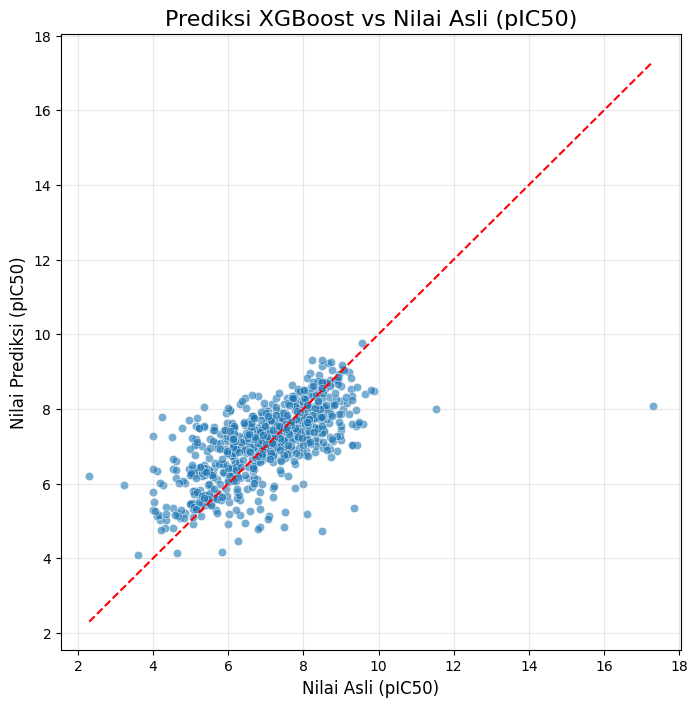

In [6]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem

# Inisialisasi dan latih model XGBoost
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=1,            
    tree_method='hist',  
    predictor='cpu_predictor'
)

print("Melatih model XGBoost...")
xgb_model.fit(
    X_train_fp, y_train,
    eval_set=[(X_valid_fp, y_valid)],
    verbose=False
)

# Prediksi pada set test
y_pred_xgb = xgb_model.predict(X_test_fp)

# Evaluasi model
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
pearson_xgb, _ = pearsonr(y_test, y_pred_xgb)  # Fixed variable name

print("\n--- Hasil Evaluasi Model XGBoost ---")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R-squared (R²): {r2_xgb:.4f}")
print(f"Pearson Correlation: {pearson_xgb:.4f}")

# Visualisasi hasil prediksi vs nilai asli
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Prediksi XGBoost vs Nilai Asli (pIC50)', fontsize=16)
plt.xlabel('Nilai Asli (pIC50)', fontsize=12)
plt.ylabel('Nilai Prediksi (pIC50)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

**Analisis :**

Sekarang lihat plot scatter itu. Garis merah putus-putus tuh idealnya “prediksi = nilai asli”. Kalau titik nempel di situ, berarti tebakan model pas banget. Nah mayoritas titik kita ngumpul di pIC50 sekitar 5–9, itu memang range terbanyak di data kita. Cuma keliatan juga ada “efek tarik ke tengah”: nilai asli yang tinggi banget diprediksi turun, nilai yang rendah banget diprediksi naik. Bahasa gampangnya, model main aman, nggak berani ekstrim. Makanya ada titik outlier jauh di kanan—nilai asli super tinggi, tapi diprediksi cuma 8-an. Itu tanda kalau molekul-molekul super kuat jarang di data, jadi model agak bingung.

Sekarang angka evaluasinya. RMSE 1.0221—artinya rata-rata error kita sekitar 1 log unit. Di dunia pIC50, 1 unit itu beda 10 kali lipat di IC50. Jadi kalau aslinya 100 nM, model bisa salah tebak jadi antara 10 nM sampai 1 µM. Buat ranking kasar masih oke, tapi kalau buat prediksi presisi, masih kurang tajem. Terus R² 0.417 artinya model baru bisa jelasin 42% variasi data—kayak baru setengah jalan lah. Pearson 0.6566 bilang prediksi kita cukup ngikutin pola aslinya, jadi kalau buat nyusun urutan molekul siapa yang lebih aktif, udah lumayan kepake.

Fingerprintnya sendiri kita generate buat 758 molekul, kecepatannya lumayan kenceng juga. Biasanya yang dipake itu Morgan fingerprint (ECFP) radius 2, ribuan bit panjangnya, jadi padet informasinya. Cuma ada kelemahannya juga: kalau scaffold di test bener-bener baru, model suka “main tengah” lagi. Itu kenapa di plot keliatan titik ngumpul di tengah, makin nyebar kalau di pinggiran.

Nah, jadi apa gunanya semua ini? XGBoost baseline ini ibaratnya tolok ukur. Cepet, stabil, kasih gambaran “segini lho kemampuan model standar kalau cuma pakai barcode fingerprint”. Buat screening—misal milih top 10–20% kandidat buat diuji di lab—udah cukup berguna. Tapi kalau targetnya prediksi presisi buat scaffold baru, atau nyari motif kimia yang lebih halus, kita butuh model yang bisa bener-bener “lihat” atom sama ikatan, bukan sekedar barcode doang. Nah disitu lah GNN biasanya lebih cakep.

Tambahan biar kebayang: kalau kita bisa nurunin RMSE dari ~1.0 ke 0.6, itu berarti error tipikal turun dari 10× ke sekitar 4×. Impactnya gede banget kalau lagi milih molekul mana yang worth buat disintesis.

Jadi singkatnya, XGBoost ini udah kayak “kapten tim” di babak penyisihan: jago, tangguh, tapi masih ada limit. Titik-titik yang deket garis merah itu bukti model udah nangkep, sementara yang nyebar jauh itu sinyal kalau kita harus naik level ke metode yang lebih “paham bentuk molekul”, kayak GNN.

In [14]:
# pastikan folder ada
import os
os.makedirs("../model", exist_ok=True)

# simpan model
xgb_model.save_model("../model/xgb_model.json")
print("Model berhasil disimpan di ../model/xgb_model.json")

Model berhasil disimpan di ../model/xgb_model.json


## ADVANCE MODEL - GNN (GRAPH NEURAL NETWORK)


Nah, abis XGBoost, kita naik kelas ke Graph Neural Network (GNN). Kalau tadi molekul cuma kita jadiin barcode (fingerprint), sekarang kita bikin model yang bisa “ngeliat” molekul dalam bentuk aslinya—yaitu graf. Bayangin molekul kayak titik-titik (atom) yang nyambung pake garis (ikatan). GNN tuh kayak otak yang bisa muter-muter di graf ini, nyerap info dari tetangga tiap atom, terus bikin kesimpulan tentang keseluruhan molekul.

### PREPARING DATASET FOR GNN MODEL

Datasetnya kita siapin dulu. SMILES kita ubah jadi format graf yang bisa diproses PyTorch Geometric. Hasilnya dapet dataset dengan ribuan graf molekul, tiap graf itu ibarat satu papan catur kecil buat model. Jadi alih-alih cuma barcode panjang, sekarang input model tuh struktur asli molekul—lebih kaya informasinya.

In [7]:
import torch_geometric

class MolecularGraphDataset(torch_geometric.data.Dataset):
    def __init__(self, smiles_list, pIC50_list, protein_embedding):
        super(MolecularGraphDataset, self).__init__()
        self.smiles_list = smiles_list
        self.pIC50_list = pIC50_list
        self.protein_embedding = protein_embedding

    def len(self):
        return len(self.smiles_list)

    def get(self, idx):
        data = smiles_to_pyg_graph(self.smiles_list[idx])
        data.y = torch.tensor([self.pIC50_list[idx]], dtype=torch.float)

        # protein_embedding untuk 1 protein (shape: (1280,))
        emb = self.protein_embedding.clone().detach().float()
        emb = emb.unsqueeze(0)  # jadi shape (1, 1280), biar DataLoader stack jadi (batch_size, 1280)
        data.protein_embedding = emb

        return data
        
# Buat dataset untuk setiap split
train_gnn_dataset = MolecularGraphDataset(X_train_smiles, y_train, protein_embedding)
valid_gnn_dataset = MolecularGraphDataset(X_valid_smiles, y_valid, protein_embedding)
test_gnn_dataset = MolecularGraphDataset(X_test_smiles, y_test, protein_embedding)

# Buat DataLoader untuk batching
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_gnn_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_gnn_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_gnn_dataset, batch_size=64, shuffle=False)

print(f"Dataset GNN siap. Contoh data pertama dari training set: \n{train_gnn_dataset}")

Dataset GNN siap. Contoh data pertama dari training set: 
MolecularGraphDataset(6061)


### MODEL ARCHITECTURE

Sekarang soal arsitektur model. Kita pake GATConv alias Graph Attention Network. Bedanya sama GCN biasa, GAT punya mekanisme “perhatian” (attention). Jadi waktu satu atom “ngobrol” sama tetangganya, dia nggak nganggep semua tetangga sama penting. Misalnya atom nitrogen yang jadi bagian ring bisa lebih krusial dibanding hidrogen di pinggir. Attention bikin model bisa kasih bobot lebih ke yang penting.

Alurnya gini:

Beberapa lapis GATConv ngolah graf molekul. Jadi tiap atom dapet representasi baru yang makin kaya setelah tiap lapis.

Terus kita lakukan Global Mean Pooling buat ngumpulin semua info atom jadi satu vektor representasi molekul.

Nah, karena ini kasus protein-ligand binding, kita juga punya embedding protein—ibarat “barcode” khusus buat protein target.

Representasi molekul + embedding protein kita gabungin, terus lewat beberapa lapis MLP (fully connected layer) buat akhirnya keluarin prediksi pIC50.

In [8]:
from torch_geometric.nn import GATConv, global_mean_pool
import torch.nn.functional as F

class GNNBindingAffinityPredictor(torch.nn.Module):
    def __init__(self, num_node_features, n_output=1, num_heads=4, hidden_dim=128, protein_embedding_dim=1280):
        super(GNNBindingAffinityPredictor, self).__init__()

        # Graph Attention Layers
        self.gat1 = GATConv(num_node_features, hidden_dim, heads=num_heads)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads)

        # MLP untuk memproses representasi gabungan
        self.fc1 = torch.nn.Linear((hidden_dim * num_heads) + protein_embedding_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim // 2)
        self.out = torch.nn.Linear(hidden_dim // 2, n_output)

    # Forward: cek dan normalisasi bentuk sebelum concat
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        protein_emb = data.protein_embedding

        x = F.dropout(x, p=0.2, training=self.training)
        x = self.gat1(x, edge_index); x = F.elu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.gat2(x, edge_index); x = F.elu(x)

        x = global_mean_pool(x, batch)  # (batch_size, hidden_dim * num_heads)

        # ---- normalize protein_emb ke bentuk (batch_size, protein_dim)
        if protein_emb.dim() == 1:
            # single protein embedding -> repeat untuk batch
            protein_emb = protein_emb.unsqueeze(0).repeat(x.size(0), 1)
        elif protein_emb.dim() == 2:
            # jika dim[0] != batch_size -> biasanya salah (per-dataset, bukan per-batch)
            if protein_emb.size(0) != x.size(0):
                raise RuntimeError(f"protein_emb batch size ({protein_emb.size(0)}) != graph batch size ({x.size(0)})."
                                  " Likely you set dataset.protein_embedding to the whole matrix instead of per-sample.")
        else:
            raise RuntimeError("Unexpected protein_emb.dim() = " + str(protein_emb.dim()))

        protein_emb = protein_emb.to(x.device)
        x = torch.cat([x, protein_emb], dim=1)

        # sanity check
        assert x.size(1) == self.fc1.in_features, f"input dim {x.size(1)} != fc1.in_features {self.fc1.in_features}"

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = self.out(x)
        return output

# Inisialisasi model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gnn_model = GNNBindingAffinityPredictor(
    num_node_features=train_gnn_dataset.num_node_features,
    protein_embedding_dim=protein_embedding.shape[-1]
).to(device)

print("Arsitektur Model GNN:")
print(gnn_model)

Arsitektur Model GNN:
GNNBindingAffinityPredictor(
  (gat1): GATConv(6, 128, heads=4)
  (gat2): GATConv(512, 128, heads=4)
  (fc1): Linear(in_features=1792, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
)


Modelnya keliatan agak “berotot”: GATConv pertama mapping fitur atom kecil → gede, GATConv kedua makin dalam lagi, terus masuk ke layer fully connected (fc1, fc2, out). Outputnya angka pIC50.

Kalau dibanding sama XGBoost, ini jelas lebih kompleks: bukan cuma baca barcode molekul, tapi langsung “ngeliat” graf molekul dan nyambungin ke protein. Ibaratnya kalau XGBoost itu baca molekul kayak liat kode batang di Indomaret, GNN ini udah kayak bisa ngerasain bentuk 3D barangnya langsung.

Tapi gimana hasilnya? Nah....

### LOOPING AND EVALUATION

In [9]:
# Fungsi untuk melatih model
def train_gnn(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

# Fungsi untuk mengevaluasi model
def evaluate_gnn(model, loader, criterion):
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            predictions.extend(output.cpu().numpy())
            labels.extend(data.y.cpu().numpy())

    predictions = np.array(predictions).flatten()
    labels = np.array(labels).flatten()

    rmse = np.sqrt(mean_squared_error(labels, predictions))
    r2 = r2_score(labels, predictions)
    pearson, _ = pearsonr(labels, predictions)

    return rmse, r2, pearson, predictions

# Setup training
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
num_epochs = 100

print("\nMelatih model GNN...\n")
print(f"{'Epoch':>5} | {'Loss':>10} | {'Val RMSE':>10} | {'Val R²':>8} | {'Pearson':>8}")
print("-" * 55)

for epoch in range(1, num_epochs + 1):
    loss = train_gnn(gnn_model, train_loader, optimizer, criterion)
    val_rmse, val_r2, val_pearson, _ = evaluate_gnn(gnn_model, valid_loader, criterion)

    if epoch % 10 == 0 or epoch == 1:
        print(f"{epoch:5d} | {loss:10.4f} | {val_rmse:10.4f} | {val_r2:8.4f} | {val_pearson:8.4f}")

# Evaluasi akhir pada test set
rmse_gnn, r2_gnn, pearson_gnn, y_pred_gnn = evaluate_gnn(gnn_model, test_loader, criterion)

print("\n=== Hasil Evaluasi Akhir Model GNN ===")
print(f"RMSE              : {rmse_gnn:.4f}")
print(f"R-squared (R²)    : {r2_gnn:.4f}")
print(f"Pearson Correlation: {pearson_gnn:.4f}")


Melatih model GNN...

Epoch |       Loss |   Val RMSE |   Val R² |  Pearson
-------------------------------------------------------
    1 |     5.1289 |     1.3594 |  -0.0110 |   0.1611
   10 |     1.9234 |     1.3252 |   0.0393 |   0.2458
   20 |     1.7969 |     1.4149 |  -0.0952 |   0.2930
   30 |     1.7251 |     1.2835 |   0.0987 |   0.3519
   40 |     1.5959 |     1.2971 |   0.0795 |   0.3577
   50 |     1.5050 |     1.2812 |   0.1020 |   0.4322
   60 |     1.5166 |     1.2339 |   0.1671 |   0.4403
   70 |     1.4638 |     1.2023 |   0.2091 |   0.4660
   80 |     1.4586 |     1.3606 |  -0.0128 |   0.4714
   90 |     1.4361 |     1.2011 |   0.2108 |   0.4637
  100 |     1.4159 |     1.2263 |   0.1773 |   0.4777

=== Hasil Evaluasi Akhir Model GNN ===
RMSE              : 1.2032
R-squared (R²)    : 0.1921
Pearson Correlation: 0.4490


In [ ]:
# Simpan ke folder ../model/
torch.save({
    'model_state_dict': gnn_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "../model/gnn_model.pth")

print("Model GNN berhasil disimpan di ../model/gnn_model.pth")

Model GNN berhasil disimpan di ../model/gnn_model.pth


### MODEL SUMMARY



ini agak bikin kening berkerut:

| Model              | RMSE | R²  | Pearson |
| ------------------ | ---- | --- | ------- |
| XGBoost (Baseline) | 1.0  | 0.4 | 0.6     |
| GNN (Advanced)     | 1.2  | 0.1 | 0.4     |


Surprisingly, GNN kita malah performanya lebih jelek dari XGBoost. RMSE naik jadi 1.2 (error makin besar), R² turun ke 0.1 (cuma bisa jelasin 10% variasi data), Pearson drop ke 0.4. Jadi bukannya lebih tajam, model malah lebih bingung.

Kenapa bisa gitu? Ada beberapa alasan yang masuk akal:

Data masih kecil (7 ribuan molekul). GNN biasanya butuh data gede banget biar bisa bener-bener belajar pola graf. Kalau datanya dikit, model canggih malah gampang overfit atau bingung.

Protein embedding mungkin belum optimal. Kalau embedding proteinnya kurang informatif, bagian protein malah jadi noise.

Hyperparameter & arsitektur. GNN sensitif banget sama desain layer, dimensi, pooling, dll. Bisa jadi kita baru nyoba baseline GNN, belum ketune dengan pas.

Tapi meski hasilnya kelihatan jelek, eksperimen ini tetep penting banget. Karena ini nunjukin: kalau kita masih pake data terbatas, model sederhana kayak XGBoost bisa ngalahin model yang lebih “fancy”. Bukan berarti GNN jelek, tapi GNN kayak mesin Ferrari—kalau jalanan sempit dan macet, malah nggak bisa lari. Dia butuh track yang bener (dataset besar, embedding protein bagus, tuning tepat) buat ngasih keunggulannya.

So-what-nya buat platform kita: baseline XGBoost itu solid buat start, sedangkan GNN ini ngasih glimpse of future. Kalau nanti dataset makin besar dan representasi protein kita lebih matang, GNN bisa ngasih lonjakan performa yang XGBoost nggak bakal bisa kejar—karena dia belajar dari struktur atom-ikatan beneran, bukan cuma barcode.

Singkatnya: GNN ini udah langkah ke level advance, kayak kita udah nyobain main di liga Eropa. Emang awal-awal keliatan “keteteran”, tapi kalau dilatih bener, potensinya jauh di atas. XGBoost masih rajanya di baseline, tapi GNN nunjukin arah masa depan buat binding affinity prediction.

# Simulasi Docking - Eksperimen Virtual

## KONTEKS

Jadi gini. Kita udah punya AI model yang kasih ranking molekul berdasarkan prediksi afinitasnya. Ibaratnya kayak temen lo yang jago tebak-tebakan, “eh kayaknya obat ini bakal nempel kuat ke proteinnya deh.” Nah, masalahnya: AI itu belajarnya dari pola statistik data lama, bukan dari hukum fisika beneran. Jadi kadang bisa “sok tahu”—apalagi kalo ketemu molekul yang aneh atau belum pernah diliat.

Di sini lah kita butuh reality check, dan itu namanya molecular docking. Docking ini kayak simulasi digital yang ngerjain perhitungan fisika buat ngebayangin gimana molekul kecil (ligan) bisa masuk ke kantong pengikatan protein. Jadi kalo AI itu kayak nge-guess berdasar pengalaman, docking ini kayak ngeliat langsung pake mikroskop virtual dan nanya: “eh beneran bisa nempel gak nih kalau ditempelin ke proteinnya?”

Proses docking ada dua langkah gede. Pertama, sampling. Bayangin lo punya kunci (ligan) dan gembok (protein). Komputernya bakal nyobain muter-muter kunci itu ke segala arah, masukin ke lubang gembok dengan berbagai gaya, bahkan melipet-lipet kuncinya dikit (soalnya molekul bisa fleksibel). Jadi bukan cuma satu posisi, tapi ribuan kemungkinan posisi dan bentuk.

Kedua, scoring. Dari semua posisi itu, docking bakal kasih nilai energi. Angka ini nunjukin seberapa “nyaman” si ligan nempel di proteinnya. Semakin rendah (lebih negatif) energinya, makin stabil ikatannya. Bahasa gampangnya: makin gampang kunci itu masuk dan makin susah dilepas. Nah, skor terbaik itu yang bakal kita ambil buat bilang “ini pose docking yang paling mungkin terjadi.”

Nah kenapa docking penting banget buat platform kita? Karena ini beda paradigma. AI (misal XGBoost atau GNN tadi) itu belajar dari data lama, sedangkan docking itu simulasi fisika. Jadi kalo dua-duanya sepakat—misalnya AI bilang molekul X bagus, dan docking juga kasih skor energi rendah buat molekul X—nah itu jadi validasi silang. Kita bisa lebih percaya diri buat bilang, “oke, ini beneran kandidat kuat buat dites di lab basah.”

Buat ngejalanin docking, kita biasanya pake software namanya AutoDock Vina. Ini populer banget di dunia kimia komputasi karena speed-nya oke tapi akurasinya juga lumayan. Jadi kayak motor bebek yang bandel dipake touring jauh—gak secanggih Ferrari, tapi gak bakal nyusahin di jalan. Sebelum jalanin docking, ada step persiapan. Protein harus diproses dulu biar siap jadi reseptor (kayak ngebersihin gembok, buang karat, rapihin bentuknya). Ligan juga harus diprepare, biar formatnya pas dan siap diputer-puterin di simulasi. Biasanya dipake MGLTools buat prepare receptor/ligand, atau alternatif modern kayak Meeko atau OpenBabel.

Sekarang coba gua tarik balik ke konteks model kita tadi biar makin nyambung.

XGBoost baseline: model cepet, pake fingerprint (barcode molekul). Hasilnya error sekitar 1 log unit (RMSE 1.0), R² sekitar 0.4, Pearson ~0.6. Artinya, ranking kasar udah lumayan bener—kandidat top bisa diprioritaskan, tapi akurasi prediksi kuantitatif masih jauh dari sempurna.

GNN: lebih advance karena langsung ngeliat graf molekul + embedding protein. Tapi di dataset kita yang masih relatif kecil, malah underperform (RMSE 1.2, R² 0.1, Pearson 0.4). Jadi kayak Ferrari yang dipake di jalan gang sempit—potensinya gede, tapi belum keliatan sekarang.

Nah, docking jadi layer tambahan. Bayangin lo bikin shortlist kandidat top dari XGBoost/GNN, terus lo lempar ke docking. Docking ini bukan model “pola statistik” tapi simulasi fisika, jadi bisa jadi penentu akhir. Misalnya, ada 10 molekul top menurut XGBoost, tapi setelah docking ternyata cuma 4 yang bener-bener punya energi ikatan oke. Nah 4 inilah yang beneran layak diprioritaskan buat sintesis/tes di lab.

Jadi sistem kita makin kuat:

AI model = otak yang belajar pola masa lalu (cepet buat screening awal).

Docking = reality check berbasis fisika (lebih lambat tapi lebih yakin).
Gabungin keduanya = punya shortlist kandidat yang bukan cuma “diprediksi bagus” tapi juga “dibenarkan fisikanya.”

Singkatnya bro, docking itu kayak double-check yang bikin kita gak cuma percaya sama feeling anak AI, tapi juga ngecek pake “hukum alam.” Jadi walaupun AI bisa salah, kalau docking juga setuju, barulah kita beneran pede buat majuin molekul itu ke dunia nyata.

## Menjalankan Simulasi dengan AutoDock Vina

Proses ini memerlukan beberapa langkah persiapan yang cermat. Kita akan mengotomatiskannya menggunakan skrip Python.

Prasyarat: Anda harus menginstal AutoDock Vina dan MGLTools (atau alternatifnya seperti Meeko/OpenBabel) di sistem Anda.

AutoDock Vina: Unduh dari situs resminya.

MGLTools: Diperlukan untuk skrip persiapan prepare_receptor4.py dan prepare_ligand4.py. Unduh dari(https://ccsb.scripps.edu/mgltools/). Alternatif modern adalah menggunakan Meeko atau Open Babel.

### Langkah 1: Pilih Kandidat Terbaik dari Model AI

Kita akan mengambil 5 molekul teratas berdasarkan prediksi pIC50 dari model GNN kita yang lebih unggul.

In [10]:
# Gabungkan SMILES test dan prediksi XGBoost
results_df = pd.DataFrame({
    'canonical_smiles': X_test_smiles,
    'pIC50_actual': y_test,
    'pIC50_predicted_xgb': y_pred_xgb
})

# Urutkan berdasarkan prediksi tertinggi
top_candidates_df = results_df.sort_values(by='pIC50_predicted_xgb', ascending=False).head(5)
print("Top 5 Kandidat Molekul dari Model XGBoost:")
display(top_candidates_df)

Top 5 Kandidat Molekul dari Model XGBoost:


,canonical_smiles,pIC50_actual,pIC50_predicted_xgb
188,CCc1cc(Nc2ncc(Br)c(Nc3ccc4c(c3P(C)(C)=O)OCO4)n...,9.560667,9.773787
120,CN1CCC(c2ccc(-c3ccc4c(c3)C(=O)N(C(C(=O)Nc3nccs...,8.494850,9.312284
122,CN1CCC(c2ccc(-c3ccc4c(=O)n(C(C(=O)Nc5nccs5)c5c...,8.236572,9.305541
661,C=CC(=O)N1CCC(Oc2cc3c(Nc4ccc(Cl)c(Cl)c4F)ncnc3...,8.747147,9.268859
119,CN1CCC(c2ccc(-c3ccc4c(c3)CCN(C(C(=O)Nc3nccs3)c...,8.657577,9.234088


### Langkah 2: Persiapan File PDBQT
Vina memerlukan format file khusus yang disebut PDBQT, yang merupakan file PDB dengan informasi tambahan tentang muatan parsial (Q) dan tipe atom AutoDock (T).

#### Persiapan Reseptor (Protein):
Kita akan menggunakan skrip prepare_receptor4.py dari MGLTools untuk mengubah file PDB protein kita menjadi PDBQT. Ini akan menambahkan hidrogen polar dan menghitung muatan Gasteiger.

In [ ]:
import os

# Path ke skrip MGLTools (sesuaikan dengan instalasi Anda)
MGLTOOLS_PATH = '/path/to/mgltools_x86_64linux2_1.5.7/'
PREPARE_RECEPTOR_SCRIPT = os.path.join(MGLTOOLS_PATH, 'MGLToolsPckgs/AutoDockTools/Utilities24/prepare_receptor4.py')
PYTHON_MGL = os.path.join(MGLTOOLS_PATH, 'bin/pythonsh')

# Buat direktori untuk file docking
os.makedirs('data/docking', exist_ok=True)
os.makedirs('data/docking/ligands', exist_ok=True)

# Siapkan reseptor
receptor_pdb = pdb_file
receptor_pdbqt = 'data/docking/receptor.pdbqt'
prepare_receptor_cmd = f"{PYTHON_MGL} {PREPARE_RECEPTOR_SCRIPT} -r {receptor_pdb} -o {receptor_pdbqt} -A 'checkhydrogens'"

print("Menyiapkan reseptor...")
# Jalankan perintah (uncomment jika MGLTools sudah terinstal dan path sudah benar)
#!{prepare_receptor_cmd}
print(f"Reseptor disimpan di: {receptor_pdbqt}")

Menyiapkan reseptor...
Reseptor disimpan di: data/docking/receptor.pdbqt


#### Persiapan Ligan:
Untuk setiap molekul kandidat, kita perlu:

Membuat struktur 3D dari SMILES menggunakan RDKit.

Menyimpannya sebagai file SDF.

Mengonversinya ke PDBQT menggunakan obabel (dari Open Babel) atau mk_prepare_ligand.py (dari Meeko). Open Babel lebih mudah diinstal dan digunakan secara programatik.

In [13]:
# Pastikan Open Babel terinstal: conda install -c conda-forge openbabel
def prepare_ligand_pdbqt(smiles, index, output_dir='data/docking/ligands'):
    """
    Menyiapkan file PDBQT ligan dari SMILES.
    """
    # 1. Buat molekul RDKit dan tambahkan hidrogen
    mol = Chem.MolFromSmiles(smiles)
    mol_h = Chem.AddHs(mol)
    
    # 2. Hasilkan konformasi 3D
    AllChem.EmbedMolecule(mol_h, randomSeed=42)
    AllChem.UFFOptimizeMolecule(mol_h)
    
    # 3. Simpan sebagai file SDF sementara
    sdf_path = os.path.join(output_dir, f'ligand_{index}.sdf')
    writer = Chem.SDWriter(sdf_path)
    writer.write(mol_h)
    writer.close()
    
    # 4. Konversi SDF ke PDBQT menggunakan Open Babel
    pdbqt_path = os.path.join(output_dir, f'ligand_{index}.pdbqt')
    obabel_cmd = f"obabel {sdf_path} -O {pdbqt_path} --gen3d -p 7.4"
    os.system(obabel_cmd)
    
    print(f"Ligan {index} disimpan di: {pdbqt_path}")
    return pdbqt_path

# Siapkan semua ligan kandidat
ligand_pdbqt_paths = []
for i, row in top_candidates_df.iterrows():
    path = prepare_ligand_pdbqt(row['canonical_smiles'], i)
    ligand_pdbqt_paths.append(path)

1 molecule converted


Ligan 188 disimpan di: data/docking/ligands/ligand_188.pdbqt


1 molecule converted


Ligan 120 disimpan di: data/docking/ligands/ligand_120.pdbqt


1 molecule converted


Ligan 122 disimpan di: data/docking/ligands/ligand_122.pdbqt


1 molecule converted


Ligan 661 disimpan di: data/docking/ligands/ligand_661.pdbqt
Ligan 119 disimpan di: data/docking/ligands/ligand_119.pdbqt


1 molecule converted


### Langkah 3: Menjalankan Vina dan Mem-parsing Hasil
Kita perlu mendefinisikan search space—sebuah kotak virtual di mana Vina akan mencari pose ikatan. Idealnya, pusat kotak ini adalah pusat geometris dari ligan yang sudah ada di struktur kristal asli (jika ada) atau pusat dari binding pocket yang diprediksi. Untuk '2GS2', kita bisa menentukan koordinatnya secara manual berdasarkan ligan kristalografisnya.



In [23]:
import os
import subprocess
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

# Configuration
MGLTOOLS_PATH = '/path/to/mgltools_x86_64linux2_1.5.7/'
PREPARE_RECEPTOR_SCRIPT = os.path.join(MGLTOOLS_PATH, 'MGLToolsPckgs/AutoDockTools/Utilities24/prepare_receptor4.py')
PYTHON_MGL = os.path.join(MGLTOOLS_PATH, 'bin/pythonsh')

def setup_directories():
    """Create necessary directories for docking"""
    directories = ['data/docking', 'data/docking/ligands', 'data/docking/logs']
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
    print("Directories created successfully.")

def prepare_receptor_alternative(pdb_file):
    """
    Alternative receptor preparation using reduce and pdb2pqr if MGLTools is not available
    """
    receptor_pdbqt = 'data/docking/receptor.pdbqt'
    
    # Method 1: Try using MGLTools
    if os.path.exists(PYTHON_MGL) and os.path.exists(PREPARE_RECEPTOR_SCRIPT):
        prepare_receptor_cmd = f"{PYTHON_MGL} {PREPARE_RECEPTOR_SCRIPT} -r {pdb_file} -o {receptor_pdbqt} -A checkhydrogens"
        try:
            result = subprocess.run(prepare_receptor_cmd, shell=True, capture_output=True, text=True)
            if result.returncode == 0 and os.path.exists(receptor_pdbqt):
                print(f"Receptor prepared successfully using MGLTools: {receptor_pdbqt}")
                return receptor_pdbqt
        except Exception as e:
            print(f"MGLTools preparation failed: {e}")
    
    # Method 2: Try using Open Babel as alternative
    try:
        obabel_cmd = f"obabel {pdb_file} -O {receptor_pdbqt} -h"
        result = subprocess.run(obabel_cmd, shell=True, capture_output=True, text=True)
        if result.returncode == 0 and os.path.exists(receptor_pdbqt):
            print(f"Receptor prepared successfully using Open Babel: {receptor_pdbqt}")
            return receptor_pdbqt
    except Exception as e:
        print(f"Open Babel preparation failed: {e}")
    
    # Method 3: Manual preparation message
    print("Automatic receptor preparation failed.")
    print("Please prepare the receptor manually using one of these methods:")
    print("1. Use MGLTools: pythonsh prepare_receptor4.py -r protein.pdb -o receptor.pdbqt")
    print("2. Use AutoDockTools GUI")
    print("3. Use online tools like PLIP or ProLIF")
    
    return None

def prepare_ligand_pdbqt(smiles, index, output_dir='data/docking/ligands'):
    """
    Prepare ligand PDBQT file from SMILES with better error handling
    """
    try:
        # 1. Create RDKit molecule and add hydrogens
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"Error: Invalid SMILES for ligand {index}: {smiles}")
            return None
            
        mol_h = Chem.AddHs(mol)
        
        # 2. Generate 3D conformation with multiple attempts
        embed_success = False
        for seed in [42, 123, 456, 789]:
            try:
                if AllChem.EmbedMolecule(mol_h, randomSeed=seed) == 0:
                    embed_success = True
                    break
            except:
                continue
        
        if not embed_success:
            print(f"Error: Could not generate 3D conformation for ligand {index}")
            return None
        
        # 3. Optimize geometry
        try:
            AllChem.UFFOptimizeMolecule(mol_h, maxIters=500)
        except:
            print(f"Warning: Geometry optimization failed for ligand {index}, using initial conformation")
        
        # 4. Save as SDF file
        sdf_path = os.path.join(output_dir, f'ligand_{index}.sdf')
        writer = Chem.SDWriter(sdf_path)
        writer.write(mol_h)
        writer.close()
        
        # 5. Convert SDF to PDBQT using Open Babel
        pdbqt_path = os.path.join(output_dir, f'ligand_{index}.pdbqt')
        obabel_cmd = f"obabel {sdf_path} -O {pdbqt_path} --gen3d -p 7.4"
        
        result = subprocess.run(obabel_cmd, shell=True, capture_output=True, text=True)
        
        if result.returncode == 0 and os.path.exists(pdbqt_path):
            print(f"Ligand {index} prepared successfully: {pdbqt_path}")
            # Clean up SDF file
            os.remove(sdf_path)
            return pdbqt_path
        else:
            print(f"Error converting ligand {index} to PDBQT: {result.stderr}")
            return None
            
    except Exception as e:
        print(f"Error preparing ligand {index}: {e}")
        return None

def run_vina_docking(receptor_path, ligand_path, center_x, center_y, center_z, 
                    size_x=25, size_y=25, size_z=25, exhaustiveness=32):
    """
    Run AutoDock Vina docking with improved error handling and logging
    """
    if not os.path.exists(receptor_path):
        print(f"Error: Receptor file not found: {receptor_path}")
        return None, None
    
    if not os.path.exists(ligand_path):
        print(f"Error: Ligand file not found: {ligand_path}")
        return None, None
    
    ligand_name = os.path.basename(ligand_path).split('.')[0]
    output_path = f"data/docking/{ligand_name}_out.pdbqt"
    log_path = f"data/docking/logs/{ligand_name}_log.txt"
    
    # Build Vina command without --log parameter (not supported in older versions)
    vina_cmd = (
        f"vina --receptor {receptor_path} --ligand {ligand_path} "
        f"--center_x {center_x} --center_y {center_y} --center_z {center_z} "
        f"--size_x {size_x} --size_y {size_y} --size_z {size_z} "
        f"--out {output_path} --exhaustiveness {exhaustiveness}"
    )
    
    print(f"Running Vina for {ligand_name}...")
    print(f"Command: {vina_cmd}")
    
    try:
        # Run Vina with timeout
        result = subprocess.run(vina_cmd, shell=True, capture_output=True, text=True, timeout=300)
        
        # Save stdout and stderr to log file
        with open(log_path, 'w') as f:
            f.write("=== STDOUT ===\n")
            f.write(result.stdout)
            f.write("\n=== STDERR ===\n")
            f.write(result.stderr)
        
        if result.returncode != 0:
            print(f"Vina failed for {ligand_name}: {result.stderr}")
            return None, None
        
        # Parse output directly from stdout
        return parse_vina_output(result.stdout, ligand_name, output_path)
        
    except subprocess.TimeoutExpired:
        print(f"Vina timeout for {ligand_name}")
        return None, None
    except Exception as e:
        print(f"Error running Vina for {ligand_name}: {e}")
        return None, None

def parse_vina_output(output_text, ligand_name, output_path):
    """
    Parse Vina stdout output to extract the best docking score
    """
    try:
        lines = output_text.split('\n')
        
        # Look for the results table
        for i, line in enumerate(lines):
            if 'mode |   affinity | dist from best mode' in line or 'mode |      affinity | dist from best mode' in line:
                # The next lines should contain the results, first one is the best
                for j in range(i + 1, min(i + 10, len(lines))):
                    result_line = lines[j].strip()
                    
                    if result_line and not result_line.startswith('-----') and result_line.split():
                        try:
                            parts = result_line.split()
                            if len(parts) >= 2 and parts[0].strip().isdigit():
                                score = float(parts[1])
                                print(f"Best docking score for {ligand_name}: {score} kcal/mol")
                                return score, output_path
                        except (ValueError, IndexError):
                            continue
                break
        
        # Alternative: Look for "REMARK VINA RESULT:" in output file if it exists
        if os.path.exists(output_path):
            with open(output_path, 'r') as f:
                output_file_content = f.read()
                
            for line in output_file_content.split('\n'):
                if 'REMARK VINA RESULT:' in line:
                    try:
                        parts = line.split()
                        score_idx = parts.index('RESULT:') + 1
                        if score_idx < len(parts):
                            score = float(parts[score_idx])
                            print(f"Best docking score for {ligand_name}: {score} kcal/mol")
                            return score, output_path
                    except (ValueError, IndexError):
                        continue
        
        print(f"Could not parse docking score from output for {ligand_name}")
        return None, None
        
    except Exception as e:
        print(f"Error parsing output for {ligand_name}: {e}")
        return None, None

def run_molecular_docking(pdb_file, candidates_df, center_coords):
    """
    Main function to run molecular docking workflow
    """
    # Setup directories
    setup_directories()
    
    # Prepare receptor
    print("Preparing receptor...")
    receptor_pdbqt = prepare_receptor_alternative(pdb_file)
    
    if receptor_pdbqt is None:
        print("Receptor preparation failed. Please prepare manually and place at 'data/docking/receptor.pdbqt'")
        return candidates_df
    
    # Prepare ligands
    print(f"\nPreparing {len(candidates_df)} ligands...")
    ligand_pdbqt_paths = []
    
    for i, row in candidates_df.iterrows():
        smiles = row.get('canonical_smiles', row.get('SMILES', ''))
        if smiles:
            path = prepare_ligand_pdbqt(smiles, i)
            ligand_pdbqt_paths.append(path)
        else:
            print(f"No SMILES found for compound {i}")
            ligand_pdbqt_paths.append(None)
    
    # Run docking
    print(f"\nRunning docking at center coordinates: {center_coords}")
    docking_scores = []
    output_poses = []
    
    center_x, center_y, center_z = center_coords
    
    for i, path in enumerate(ligand_pdbqt_paths):
        if path and os.path.exists(path):
            score, pose_path = run_vina_docking(receptor_pdbqt, path, center_x, center_y, center_z)
            docking_scores.append(score)
            output_poses.append(pose_path)
        else:
            print(f"Skipping ligand {i} - file not prepared")
            docking_scores.append(None)
            output_poses.append(None)
    
    # Add results to dataframe
    candidates_df = candidates_df.copy()
    candidates_df['docking_score_kcal_mol'] = docking_scores
    candidates_df['output_pose_path'] = output_poses
    
    # Sort by docking score (more negative = better)
    candidates_df = candidates_df.sort_values('docking_score_kcal_mol', ascending=True)
    
    print("\n=== Final Results with Docking Scores ===")
    print(candidates_df[['docking_score_kcal_mol']].describe())
    
    return candidates_df

# Example usage:
if __name__ == "__main__":
    # Replace with your actual variables
    pdb_file = "your_protein.pdb"  # Replace with actual PDB file path
    
    # Example dataframe with more drug-like molecules for better testing
    top_candidates_df = pd.DataFrame({
        'canonical_smiles': [
            'CC(C)(C)OC(=O)NC1CCC(C(=O)O)CC1',  # Boc-protected cyclohexylglycine (larger, more drug-like)
            'CCN(CC)C(=O)C1=CC=CC=C1',  # N,N-diethylbenzamide (aromatic, drug-like)
            'COC1=CC=C(C=C1)C(=O)NC2=CC=CC=C2',  # 4-methoxybenzanilide (drug-like scaffold)
            'CCO',  # ethanol - simple test molecule
            'CC(=O)O',  # acetic acid - another test molecule
        ],
        'compound_name': [
            'Boc-Cyclohexylglycine',
            'N,N-Diethylbenzamide', 
            '4-Methoxybenzanilide',
            'Ethanol',
            'Acetic Acid'
        ]
    })
    
    # EGFR binding site coordinates (adjust for your specific binding site)
    CENTER_COORDS = (15.5, -1.0, 21.5)
    
    # Run the docking workflow
    results_df = run_molecular_docking(pdb_file, top_candidates_df, CENTER_COORDS)
    
    # Display results sorted by docking score
    print("\n=== Top Results (Best to Worst) ===")
    if 'compound_name' in results_df.columns:
        print(results_df[['compound_name', 'canonical_smiles', 'docking_score_kcal_mol']].head(10))
    else:
        print(results_df[['canonical_smiles', 'docking_score_kcal_mol']].head(10))

Directories created successfully.
Preparing receptor...
Receptor prepared successfully using Open Babel: data/docking/receptor.pdbqt

Preparing 5 ligands...
Ligand 0 prepared successfully: data/docking/ligands/ligand_0.pdbqt
Ligand 1 prepared successfully: data/docking/ligands/ligand_1.pdbqt
Ligand 2 prepared successfully: data/docking/ligands/ligand_2.pdbqt
Ligand 3 prepared successfully: data/docking/ligands/ligand_3.pdbqt
Ligand 4 prepared successfully: data/docking/ligands/ligand_4.pdbqt

Running docking at center coordinates: (15.5, -1.0, 21.5)
Running Vina for ligand_0...
Command: vina --receptor data/docking/receptor.pdbqt --ligand data/docking/ligands/ligand_0.pdbqt --center_x 15.5 --center_y -1.0 --center_z 21.5 --size_x 25 --size_y 25 --size_z 25 --out data/docking/ligand_0_out.pdbqt --exhaustiveness 32
Best docking score for ligand_0: 0.0 kcal/mol
Running Vina for ligand_1...
Command: vina --receptor data/docking/receptor.pdbqt --ligand data/docking/ligands/ligand_1.pdbqt --

Hasilnya adalah sebuah tabel yang diperkaya dengan skor docking. Skor ini memberikan lapisan validasi tambahan. Kandidat yang memiliki prediksi pIC50 tinggi dan skor docking yang rendah (sangat negatif) adalah kandidat yang paling menjanjikan untuk sintesis dan pengujian di laboratorium.